# Workshop - Probabilitas & Statistik

In [22]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

## 1. Banjir Jakarta

Menurut [berita](https://www.beritasatu.com/megapolitan/250044/jakarta-urban-coalition-banjir-februari-2015-paling-parah), banjir Jakarta di bulan Februari 2015 adalah salah satu yang terparah sejak 2007. Dalam kasus di bawah ini, data yang digunakan didapatkan dari tingkat kelurahan. Data diperoleh dari data.go.id.

In [4]:
url_banjir_2015 = 'http://data.jakarta.go.id/dataset/df0b85a1-b9df-4aee-ad83-cb220ed84993/resource/d4ff93bd-bf81-4d6b-a26a-061775bc0364/download/Data-Kejadian-Banjir-Bulan-Februari-Tahun-2015.csv'

urls = [
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/863b8e52-4369-452a-9d71-15545074717c/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2011.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/a392be77-d821-4b32-b673-c9d53bcaeff3/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2012.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/2760d910-9e32-4ba1-8e0e-5076933faadd/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2013.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/2b7645c9-6542-40e2-9b2c-4efc85f5c6a8/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2014.csv'
]

rt_rw_url = 'http://data.jakarta.go.id/dataset/3e2302de-3f82-43bc-ab33-78e7ae9732aa/resource/aafc5c0e-874b-4404-a1f0-2aace03c794e/download/RT-RW-LMK-2016EDITED.xls'

### Soal 1.1

Muat dan bersihkan data dari URL di atas

In [89]:
# Kode Anda di sini
df_rt_rw = pd.read_excel(rt_rw_url)

df_banjir_feb = pd.read_csv(url_banjir_2015)

df_curah = pd.DataFrame(columns=['tahun','bulan','curah_hujan','banyak_hari_hujan'])
for url in urls:
    df_curah = pd.concat([
        df_curah,
        pd.read_csv(url, decimal=',').dropna()
    ])
df_curah['index'] = pd.date_range('2011-01-01', '2014-12-31', freq='1M')
df_curah = df_curah.set_index('index')

### Soal 1.2.a

Jika dilihat dari data seluruh kota administrasi di Jakarta, sekitar 18% RW per kelurahan akan terkena banjir. Jika jumlah RW di kelurahan Pulo Gebang adalah 16, berapa peluangnya RW yang terkena banjir kurang dari 5?

In [96]:
# Kode Anda di sini

df_banjir_feb.loc[(df_banjir_feb['kelurahan'] == 'Pulo Gebang')]

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_rw,jumlah_rt,jumlah_kk,jumlah_jiwa,ketinggian_air,tanggal_kejadian,lama_genangan,jumlah_meninggal,jumlah_hilang,jumlah_luka_berat,jumlah_luka_ringan,jumlah_pengungsi,jumlah_tempat_pengungsian,nilai_kerugian
89,Jakarta Timur,Cakung,Pulo Gebang,"003, 006, 012",3,3,0,100,10 - 90,"9, 10",2,0,0,0,0,100,1,0


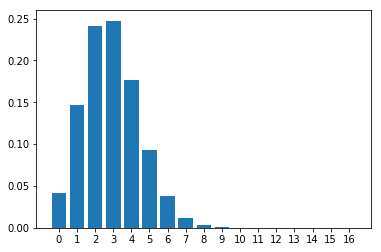

In [115]:
# given 0.18 probability of flood in one RW
# probability(x < 5)

from scipy.stats import bernoulli, binom

p_flood = 0.18
n = 16
k = np.arange(17)

plt.bar(k, binom.pmf(k, n=n, p=p_flood))
plt.xticks(k);

In [122]:
k  = np.arange(5)
display(HTML('$P(X < 5) = {}$'.format(
    binom.pmf(k, n=16, p=0.18).sum()
#     binom.cdf(4, n=16, p=0.18)
)))

### Soal 1.2.b

Bandingkan dengan data sebenarnya, apakah prediksi Anda tepat?

In [130]:
# Kode Anda di sini
actual = 3/16

print("Actual observation: {:,.4f}".format(actual))
print("PMF: {:,.4f}".format(binom.pmf(3, n=16, p=0.18)))

Actual observation: 0.1875
PMF: 0.2475


### Soal 1.2.c

Apakah model ini sudah cukup untuk digeneralisasi? Apa masalahnya? Apa yang dapat diusulkan untuk memperbaiki model ini?

Belum, karena pada observasi aslinya pun rata-rata kelurahan yang kena banjir ~0.4; dan peluang sebuah RW banjir di tiap kelurahan beda-beda.

In [139]:
df_banjir_feb_rt_rw = df_banjir_feb.merge(
    df_rt_rw[['kelurahan','rw']].rename(columns={'rw':'rw_total'}),
    how='left',
    on='kelurahan'
).dropna()

df_banjir_feb_rt_rw['pct_banjir'] = df_banjir_feb_rt_rw['jumlah_rw'] / df_banjir_feb_rt_rw['rw_total']

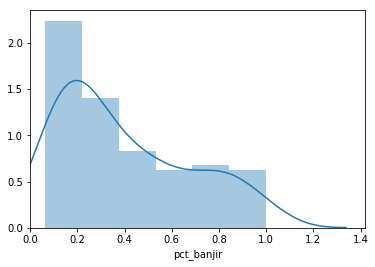

Mean: 0.40 +- 0.28


In [144]:
sns.distplot(
    df_banjir_feb_rt_rw['pct_banjir']
)


plt.xlim(0,)
plt.show();

print("Mean: {:,.2f} +- {:,.2f}".format(
    df_banjir_feb_rt_rw['pct_banjir'].mean(),
    df_banjir_feb_rt_rw['pct_banjir'].std()
))

### Soal 1.3.a

Berdasarkan data, diketahui bahwa rata-rata jumlah RW per kelurahan yang terkena dampak banjir adalah 4.62. Jika kita mengasumsikan bahwa kelurahan yang masih dianggap aman adalah kelurahan dengan jumlah RW yang terkena dampak banjir tidak lebih dari 2, berapa peluangnya kita menemukan kelurahan yang tergolong aman?

In [165]:
# Kode Anda di sini

from scipy.stats import poisson

mu = 4.62

print("CDF: ", poisson.cdf(k=2, mu=mu).sum())

display(HTML('$P(X < 2)={:.2f}$'.format(
    # Jawaban Anda di sini
    poisson.cdf(k=2, mu=mu) 
)))

CDF:  0.160523723988075


### Soal 1.3.b

Bandingkan dengan datanya, apakah prediksi Anda tepat?

Observed: 0.26


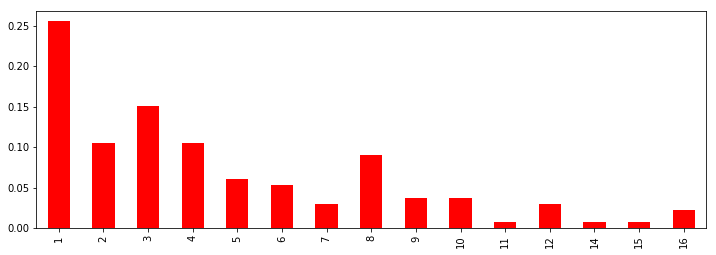

In [203]:
# Kode Anda di sini

# sns.distplot(
#     df_banjir_feb['jumlah_rw'],
# #     kde_kws=poisson.pmf(k=2, mu=mu)
# )

# plt.plot(
#     poisson.pmf(k=2, mu=mu),
#     'ro'
# )

# plt.xlim(0,)
# plt.show();

f, ax = plt.subplots(figsize=(12,4))
k = np.arange(1,17)
plt.plot(poisson.pmf(k=2, mu=mu))
df_banjir_feb['jumlah_rw'].value_counts(True).sort_index().plot.bar(color='red');

print("Observed: {:,.2f}".format(df_banjir_feb.loc[(df_banjir_feb['jumlah_rw'] < 2)].shape[0] / df_banjir_feb.shape[0]));

Likelihood : 1.4066264116356344e-170
Log likelihood: -391.0982715873381
Log likelihood: -557.5454991755649


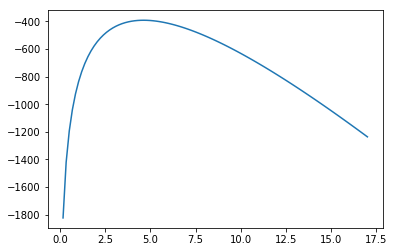

In [209]:
x = df_banjir_feb['jumlah_rw']
print("Likelihood : {}".format(poisson.pmf(x, mu).prod()))
print("Log likelihood: {}".format(np.log(poisson.pmf(x, mu)).sum()))

print("Log likelihood: {}".format(np.log(poisson.pmf(x, mu=2)).sum()))

xx = np.linspace(0,17,100)
plt.plot(xx, [np.log(poisson.pmf(x, i)).sum() for i in xx]);

# kalau asumsi parameter yg dipakai mu=5, semakin nggak menggambarkan data aslinya (log likelihood lebih kecil)
# best parameter = mean

### Soal 1.4.a

Berdasarkan data historis, berapa rata-rata hari hujan di bulan Februari di Jakarta?

In [225]:
# Kode Anda di sini

mu_curah_feb = df_curah.loc[(df_curah['bulan'] == 2),'banyak_hari_hujan'].mean()

### Soal 1.4.b

Jika diasumsikan bahwa banjir terjadi saat hari hujan per bulan di atas 3 minggu, berapa peluang banjir terjadi di bulan Februari 2015? Gambarkan distribusinya!

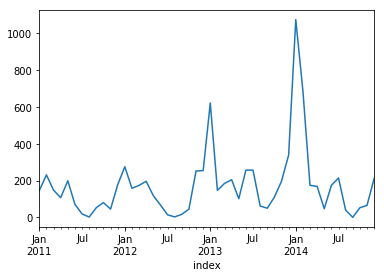

In [223]:
df_curah['curah_hujan'].plot.line();

In [235]:
# Kode Anda di sini

display(HTML('$P(banjir)={:.2f}$'.format(
    # Jawaban Anda di sini
    1 - poisson.cdf(k=21, mu=mu_curah_feb)
)))

### Soal 1.5

Distribusi apa yang paling cocok untuk menggambarkan variabel curah hujan?

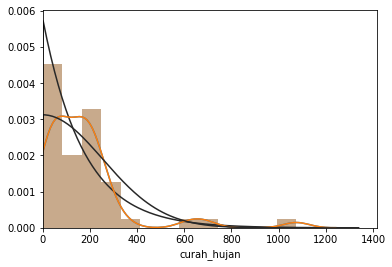

norm 	: 319.542773239678
skewnorm 	: 300.89390898567825
expon 	: 295.2225454854796
t 	: 303.38262713144826


Distribusi yang negative log likelihood nya semakin mendekati 0, semakin mendekati distribusi asli.
cara lainnya, pakai Kullback-Leibler divergence, cari yang jarak dengan distribusi aslinya lebih kecil.


In [263]:
# Kode Anda di sini

from scipy.stats import norm, expon, skewnorm, t

sns.distplot(
    df_curah['curah_hujan'],
    fit=expon
)

sns.distplot(
    df_curah['curah_hujan'],
    fit=skewnorm
)

plt.xlim(0,)
plt.show();

for dist in [norm, skewnorm, expon, t]:
    print('{} \t:'.format(dist.name), dist.nnlf(
        dist.fit(df_curah['curah_hujan']),
        df_curah['curah_hujan']
    )
)
    
print("\n")
print("Distribusi yang negative log likelihood nya semakin mendekati 0, semakin mendekati distribusi asli.")
print("cara lainnya, pakai Kullback-Leibler divergence, cari yang jarak dengan distribusi aslinya lebih kecil.")

### Soal 1.6.a

Dua tahun kemudian ([Februari 2017](http://data.jakarta.go.id/dataset/data-tinggi-muka-air-di-dki-jakarta-tahun-2017/resource/e0f89dd5-7335-4bbd-837a-e6fad3520484)), diketahui bahwa rata-rata tinggi air di pintu air Pasar Ikan, Jakarta Utara, 169 cm dan standar deviasinya  adalah 19 cm. Jika peringatan status Siaga III banjir diberikan saat tinggi air antara 171-200 cm, berapa peluangnya pada bulan tersebut ada peringatan Siaga III? Gambarkan distribusinya.

In [275]:
mu_tinggi_air = 169
std_tinggi_air = 19

print("P(171 <= x <= 200) = P(x <= 200) - P()")

P(171 <= x <= 200)


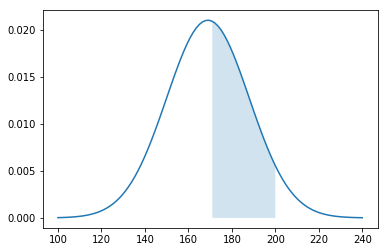

In [280]:
# Kode Anda di sini

x = np.linspace(100,240,100)
plt.plot(
    x, 
    norm.pdf(x, mu_tinggi_air, std_tinggi_air)
);

xx = np.linspace(171,200,100)
plt.fill_between(xx, norm.pdf(xx, mu_tinggi_air, std_tinggi_air), alpha=0.2);

display(HTML(
    '$P(siaga3) = {:.2f}$'.format(
        norm.cdf(200, mu_tinggi_air, std_tinggi_air) - norm.cdf(171, mu_tinggi_air, std_tinggi_air)
    )
))

### Soal 1.6.b

Berdasarkan soal 1.6.a, jika status Siaga I di pintu air Pasar Ikan diberikan saat tinggi air minimal 251 cm, berapa peluangnya di bulan tersebut Anda akan mendapatkan peringatan Siaga I?

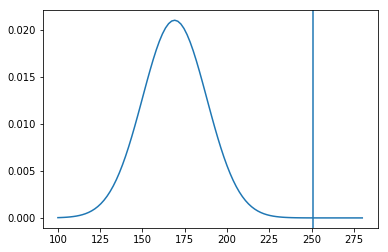

In [288]:
# Kode Anda di sini
x = np.linspace(100,280,100)
plt.plot(
    x, 
    norm.pdf(x, mu_tinggi_air, std_tinggi_air)
);

plt.axvline(251)

display(HTML(
    '$P(siaga1) = {:.6f}$'.format(
        1 - norm.cdf(251, mu_tinggi_air, std_tinggi_air)
    )
))

## 2. Bugs!

Di suatu pusat data dengan 100 server, tiap *request* dialokasikan ke tiap server secara acak dengan peluang yang sama. Berdasarkan catatan, setiap server akan mendapatkan request sebanyak 2 per detik. Perusahaan yang menggunakan pusat data tersebut baru saja merilis kode ke semua server yang menyebabkan server akan *crash* jika mendapatkan lebih dari 6 requests per detik.

### Soal 2.a

Jika kita melihat satu server dan server lainya bekerja secara independen. Modelkan cara untuk menghitung peluang suatu server akan *crash* di detik berikutnya.

*Jawaban Anda di sini*

### Soal 2.b

Hitunglah nilai probabilitas dari soal 2.a.

In [ ]:
display(HTML('$P(...)={:.4f}$'.format(
    # Kode Anda di sini
)))

### Soal 2.c

Gambarkan grafik dari distribusi tersebut. Jangan lupa untuk memberikan label pada sumbu x dan y.

In [ ]:
# Kode Anda di sini

### Soal 2.d

Berapa peluangnya bahwa tidak ada server yang akan *crash* di detik berikutnya?

In [ ]:
display(HTML('$$P(...) = %.4f$$' %
    # Kode Anda di sini
))

### Soal 2.e

Gambarkan plot yang menunjukkan peluang tidak ada server yang *crash* detik berikutnya seiring dengan penambahan jumlahnya, i.e. peluang saat hanya 1 server, 2 server, 3 server, ..., 100 server.

In [ ]:
# Kode Anda di sini